# 🎓 YOLOv11 Thesis Training Notebook

**Project:** Waste Detection System (XAI-CBAM)

**Author:** Ramazan YILDIZ & Samın FEYZI

This notebook is designed to train `YOLOv11` on the consolidated Waste Detection dataset.
It maximizes result output (Plots, Curves, Confusion Matrices) for thesis documentation.

## 1. ⚙️ Setup Environment
Install Ultralytics and import required libraries.

In [6]:
!pip install ultralytics -q

import torch
if not torch.cuda.is_available():
    print("⚠️ WARNING: You are running on CPU! Go to Runtime > Change runtime type > GPU")
else:
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")

import ultralytics
from ultralytics import YOLO
import os
import shutil
import yaml

ultralytics.checks()

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.6/112.6 GB disk)


## 2. 📂 Connect to Google Drive & Load Dataset
1. **Upload** `merged_dataset.zip` to your Google Drive root folder.
2. This cell will mount drive and unzip the data.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Copy and Unzip (Force Overwrite)
!cp /content/drive/MyDrive/merged_dataset.zip /content/
!unzip -o -q merged_dataset.zip -d /content/

# --- 🔧 FIX DATA.YAML PATHS ---
yaml_path = '/content/merged_dataset/data.yaml'

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Update path to be local to Colab
data['path'] = '/content/merged_dataset'
data['train'] = 'train/images'
data['val'] = 'valid/images'
data['test'] = 'test/images'

with open(yaml_path, 'w') as f:
    yaml.dump(data, f)

print("✅ Dataset Ready & Paths Fixed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset Ready & Paths Fixed!


## 3. 🏋️‍♂️ Train YOLOv11 Model
Using `yolo11m.pt` (Medium) for better accuracy for the thesis, or `yolo11n.pt` for speed.
- `epochs=100`: Sufficient for convergence.
- `plots=True`: Saves all analysis plots.
- `imgsz=640`: Standard resolution.
- `patience=20`: Early stopping if no improvement.

In [9]:
# Load Model
model = YOLO('yolo11m.pt')

# Train
results = model.train(
    data='/content/merged_dataset/data.yaml',
    project='/content/drive/MyDrive/YOLO_Runs',
    name='yolo11_medium_thesis',
    epochs=100,
    imgsz=640,
    batch=64,
    workers=8,
    plots=True,
    save=True,
    device=0,
    verbose=True,
    patience=20,
    optimizer='auto'
)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/merged_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_medium_thesis3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, pers

## 4. 📊 Validation & Metrics Analysis
Display the key graphs for your thesis.

In [10]:
metrics = model.val()

print(f"mAP50: {metrics.box.map50}")
print(f"mAP50-95: {metrics.box.map}")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1011.9±576.2 MB/s, size: 27.5 KB)
val: Scanning /content/merged_dataset/valid/labels.cache... 4136 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4143/4143 7.7Mit/s 0.0s
val: /content/merged_dataset/valid/images/d2_08_frame_012200_PNG_jpg.rf.4de771dd2231efb220a8a0c7425163b6.jpg: 3 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5850, len(boxes) = 9351. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 259/259 10.1it/s 25.8s
                   all       4143       9351       0

### 📉 Training Curves

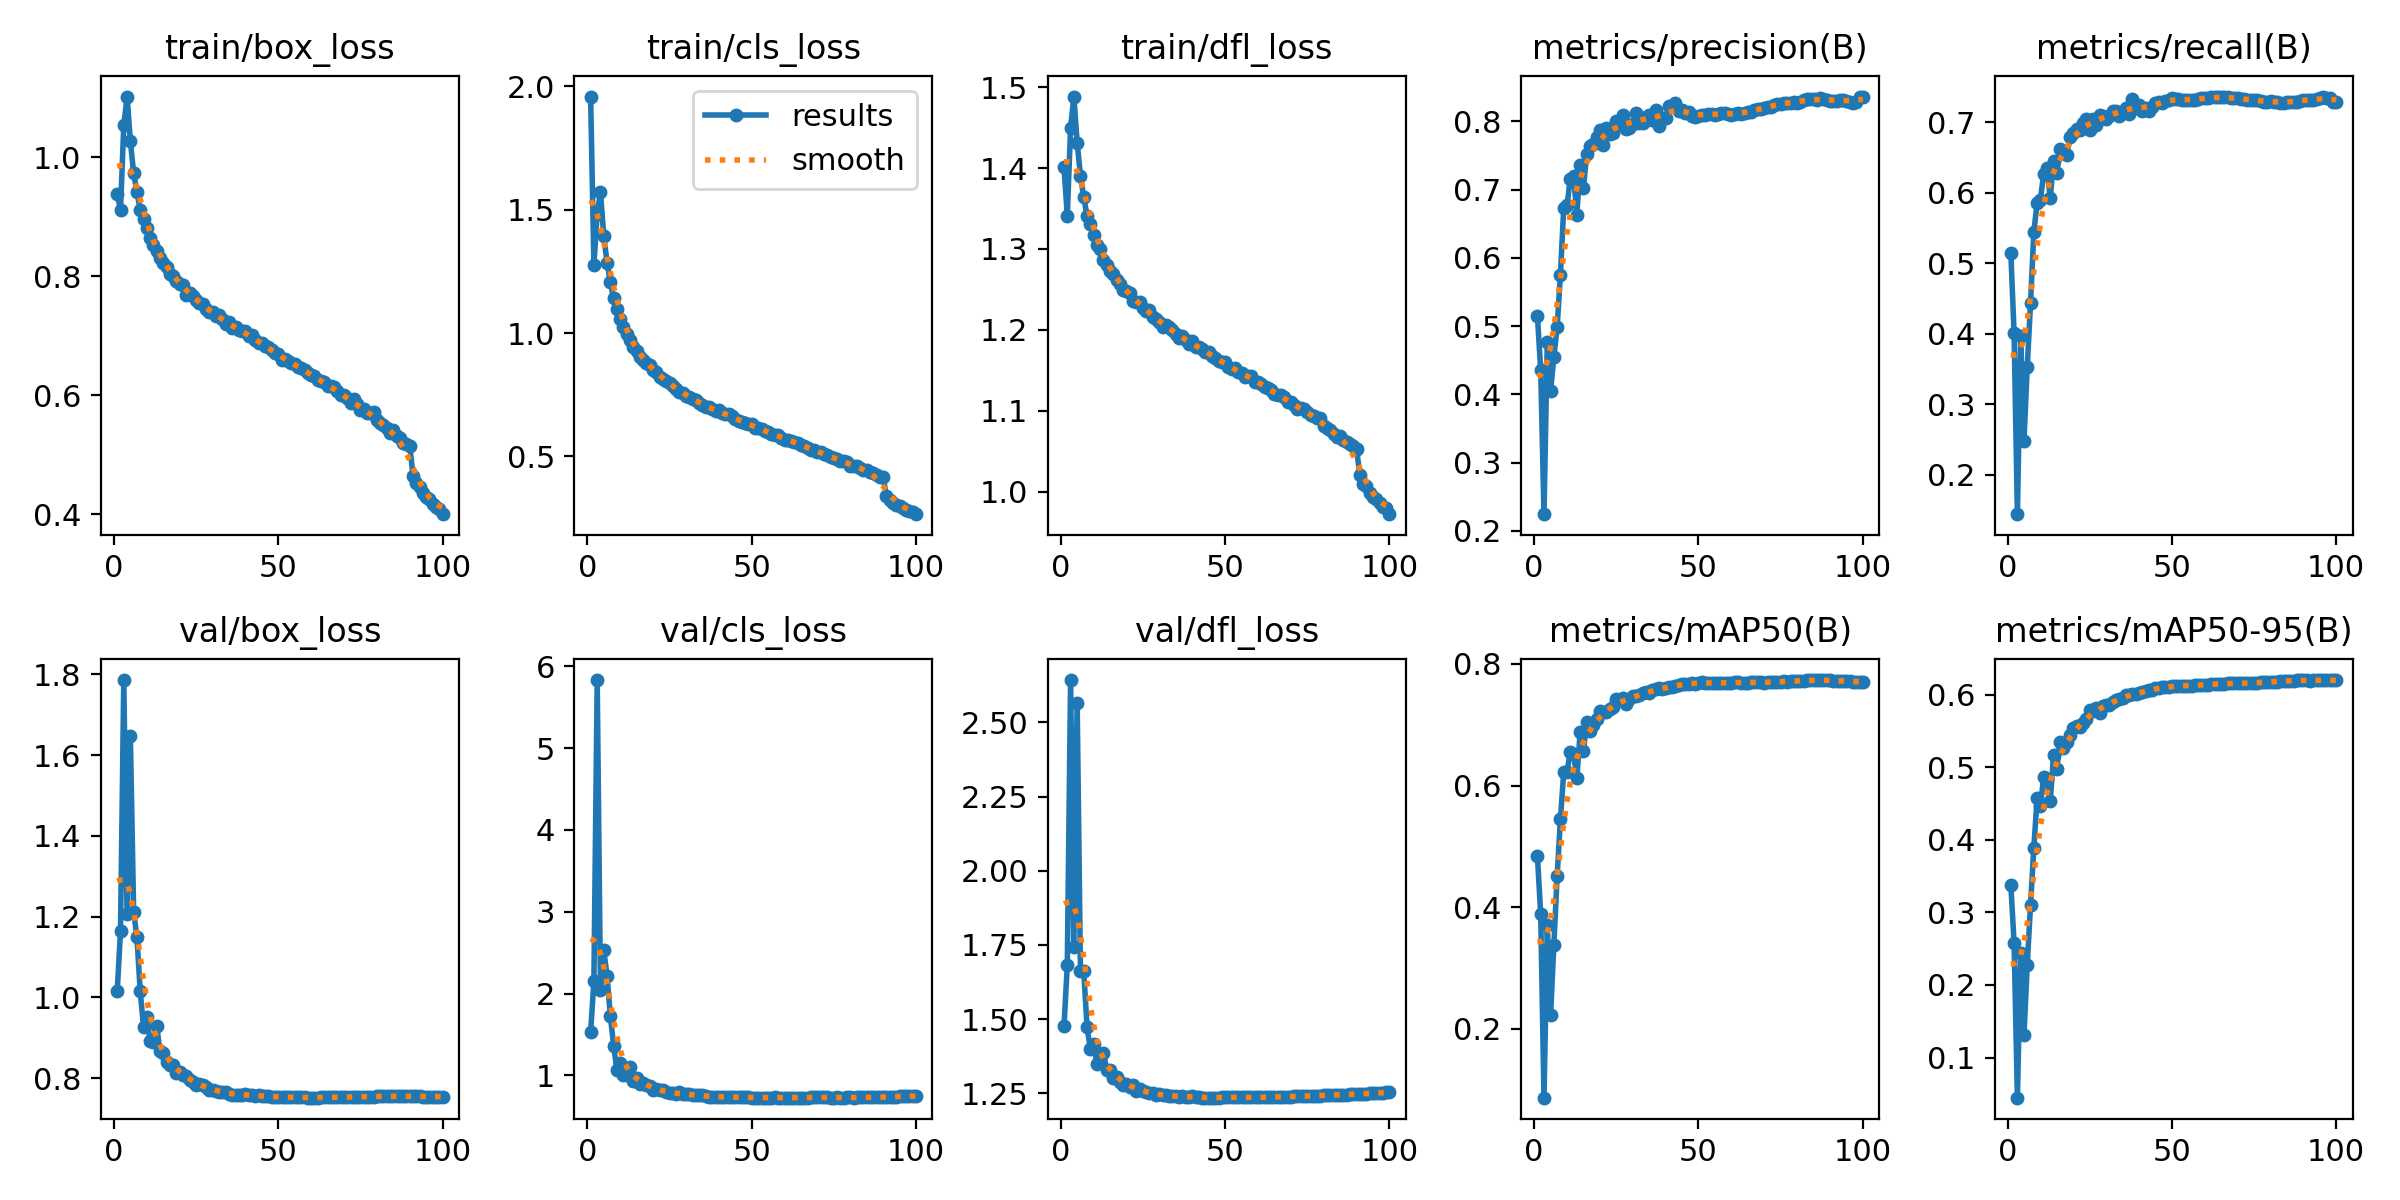

In [11]:
display(Image(filename=f'{model.trainer.save_dir}/results.png'))

### 🧩 Confusion Matrix
Critical for analyzing class-specific errors.

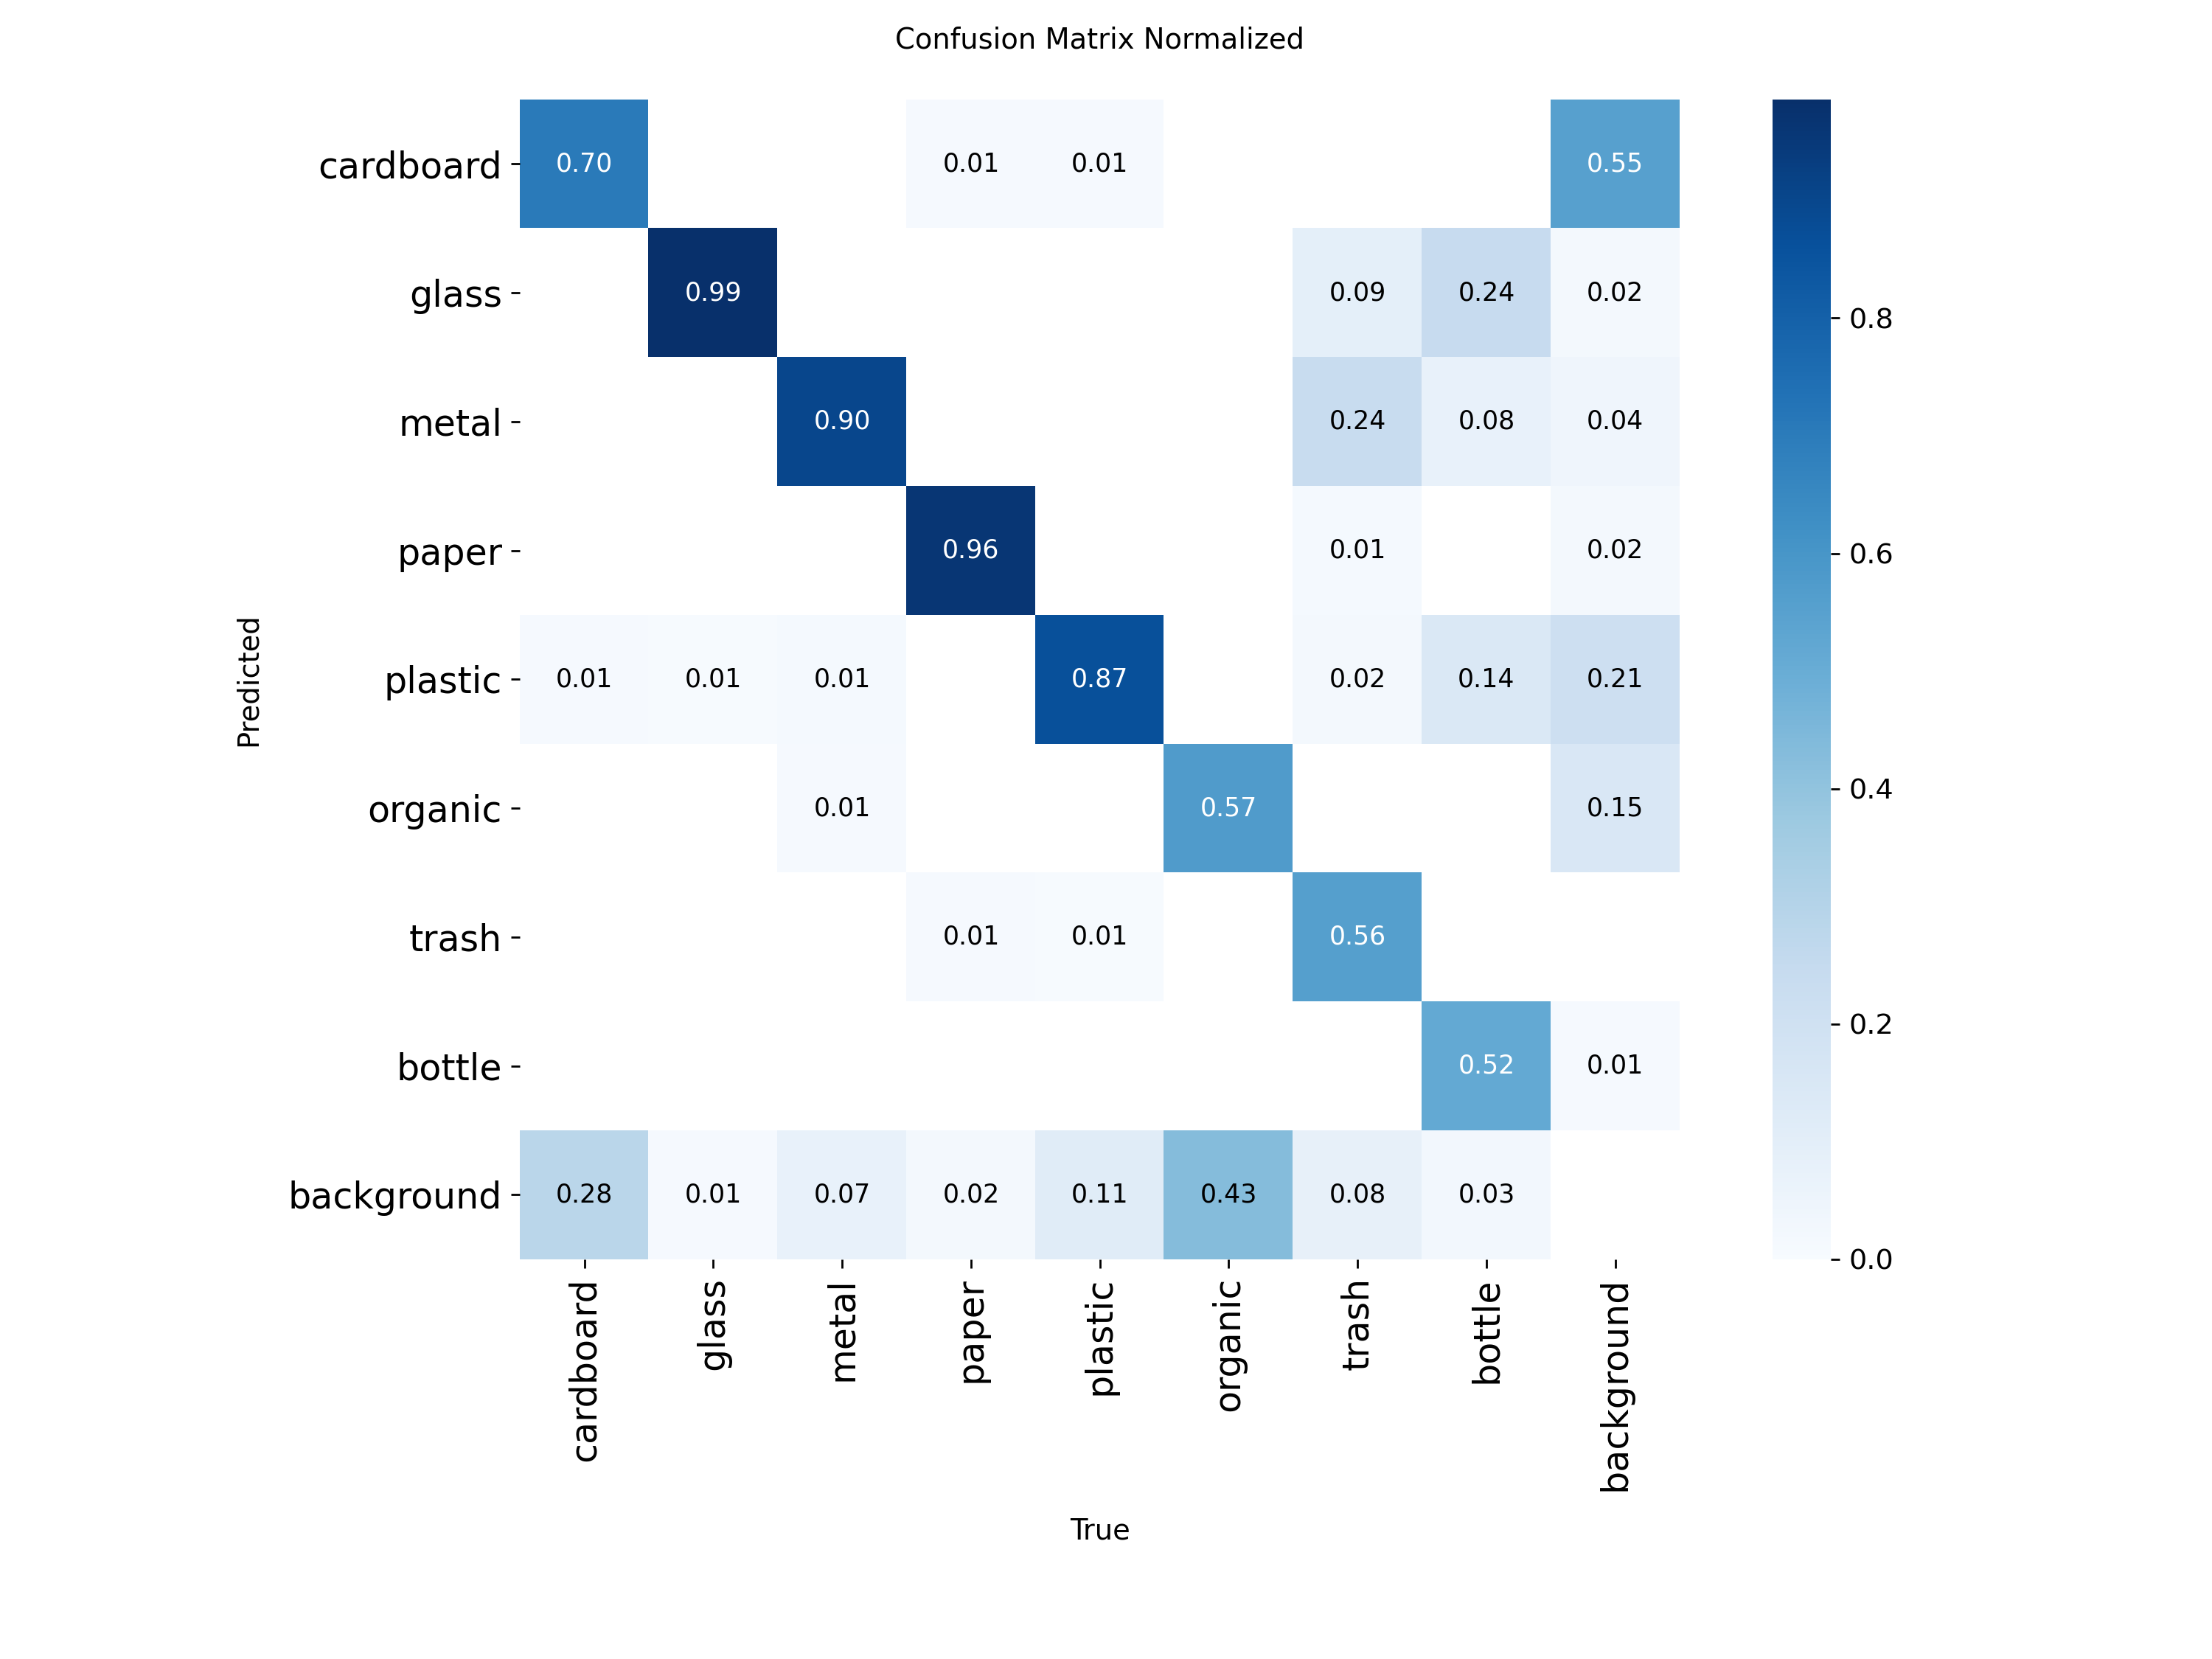

In [12]:
display(Image(filename=f'{model.trainer.save_dir}/confusion_matrix_normalized.png'))

### 📈 Precision-Recall Curve

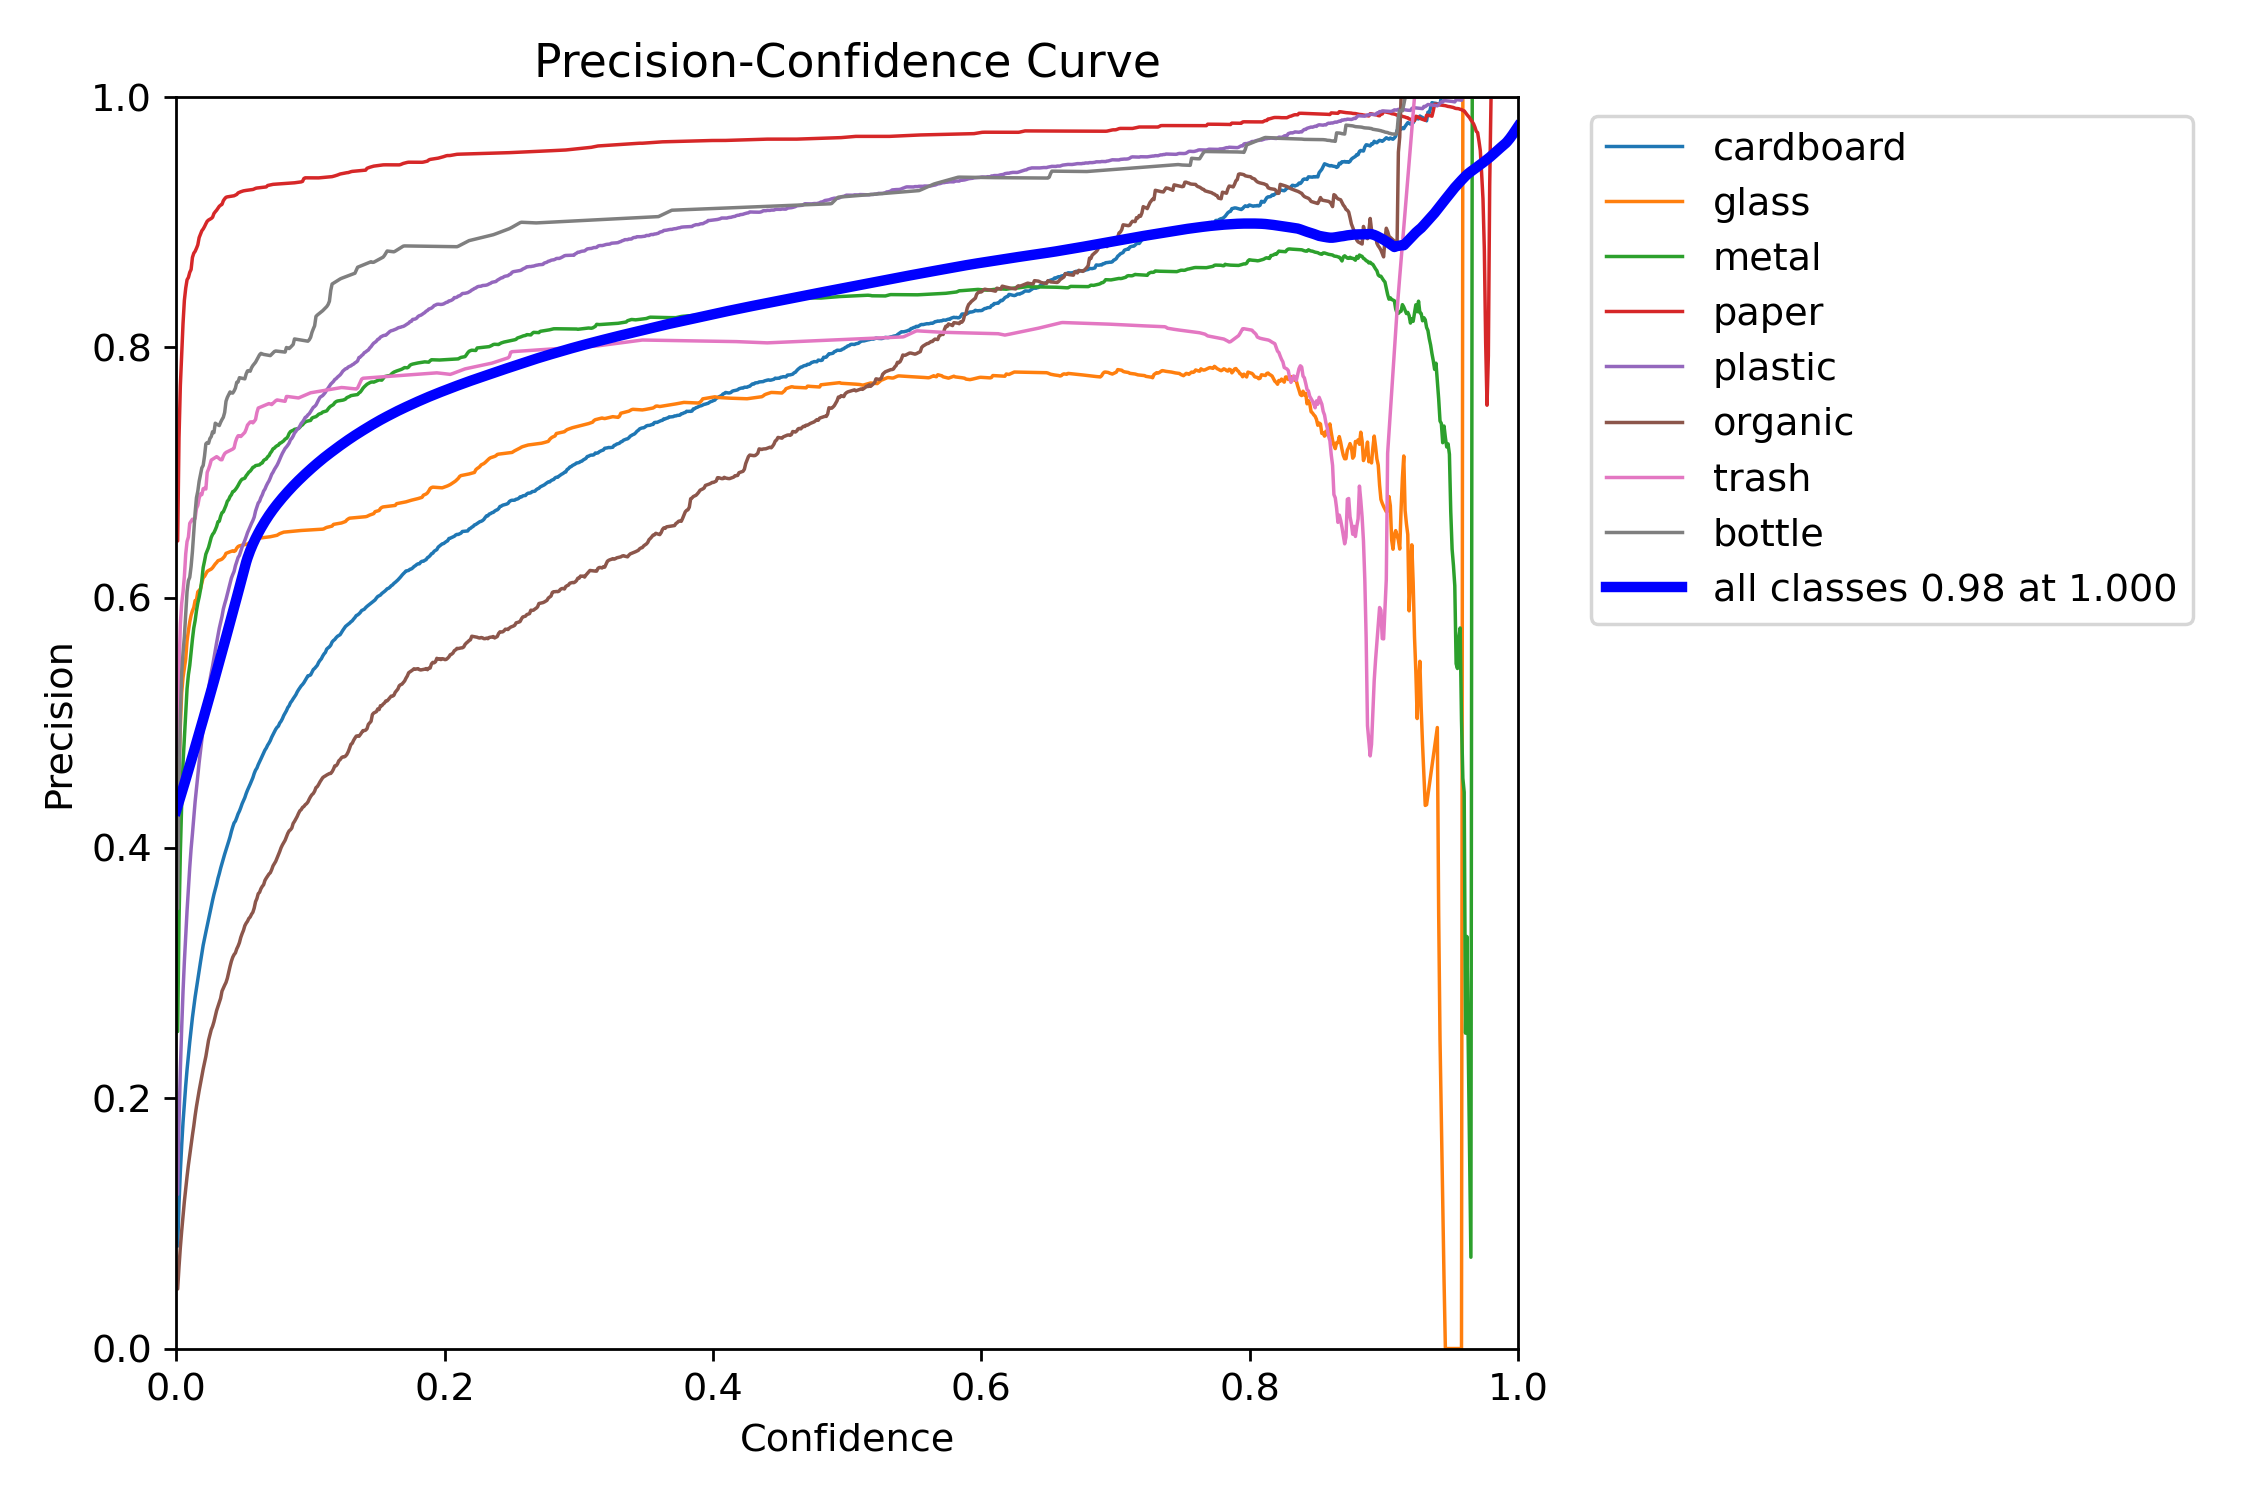

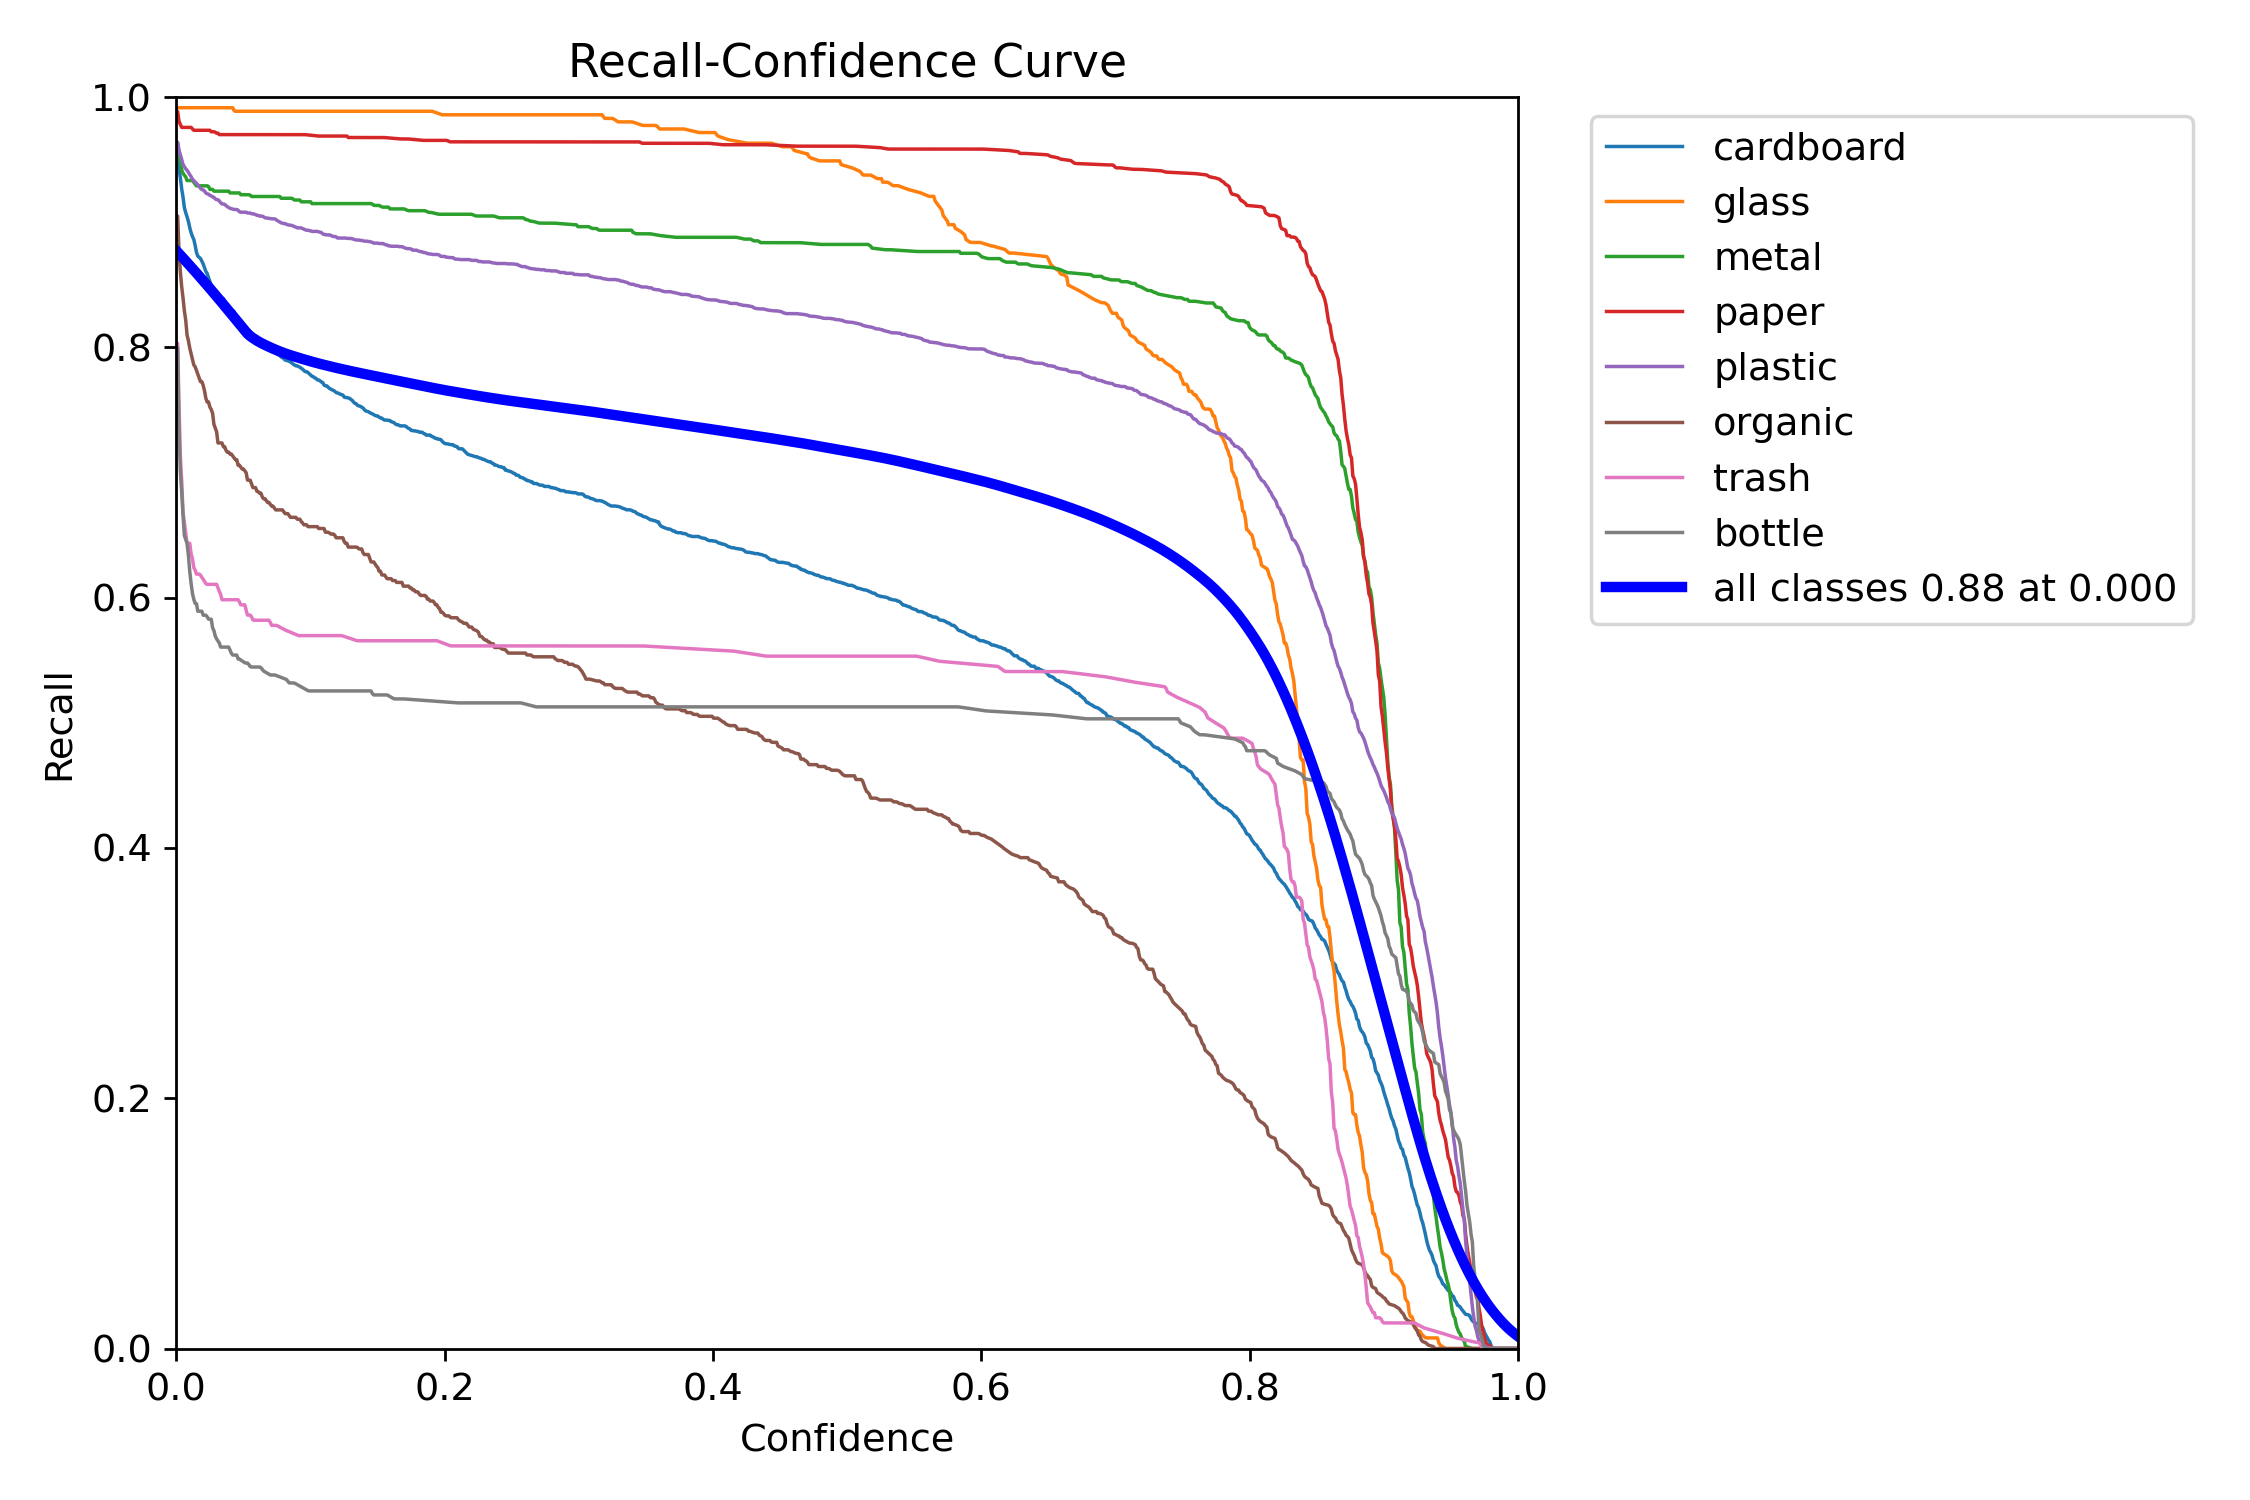

In [18]:
display(Image(filename=f'{model.trainer.save_dir}/BoxP_curve.png'))
display(Image(filename=f'{model.trainer.save_dir}/BoxR_curve.png'))

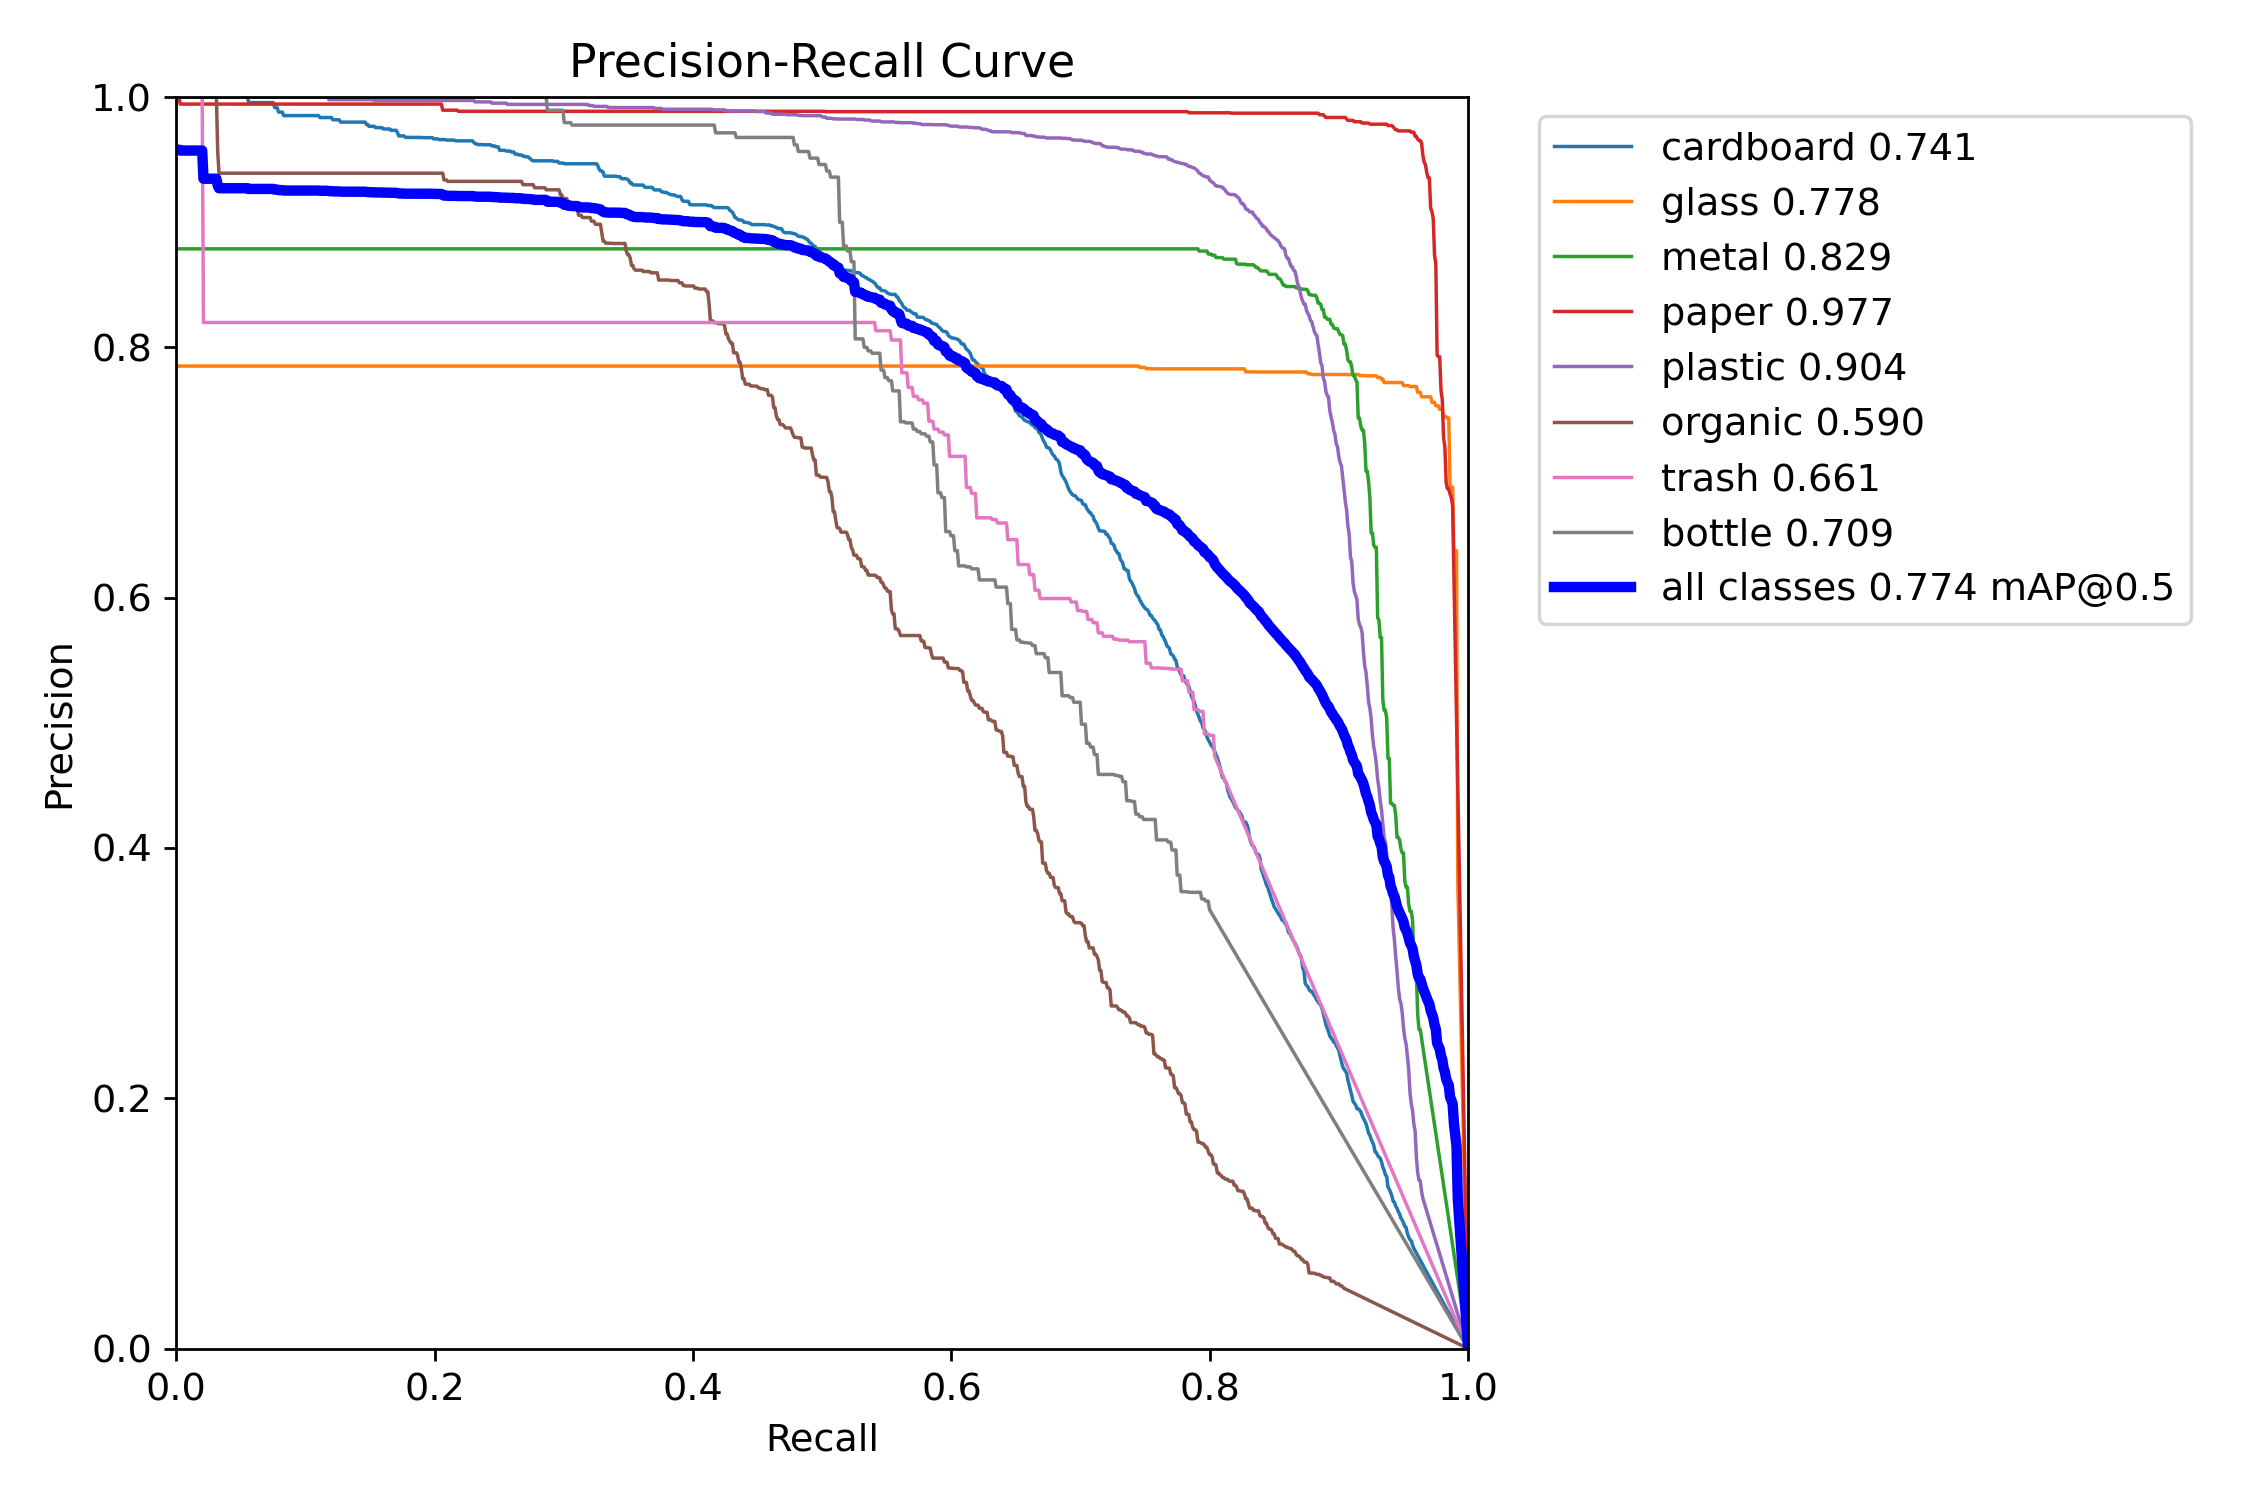

In [23]:
display(Image(filename=f'{model.trainer.save_dir}/BoxPR_curve.png'))

### ⚖️ F1-Confidence Curve

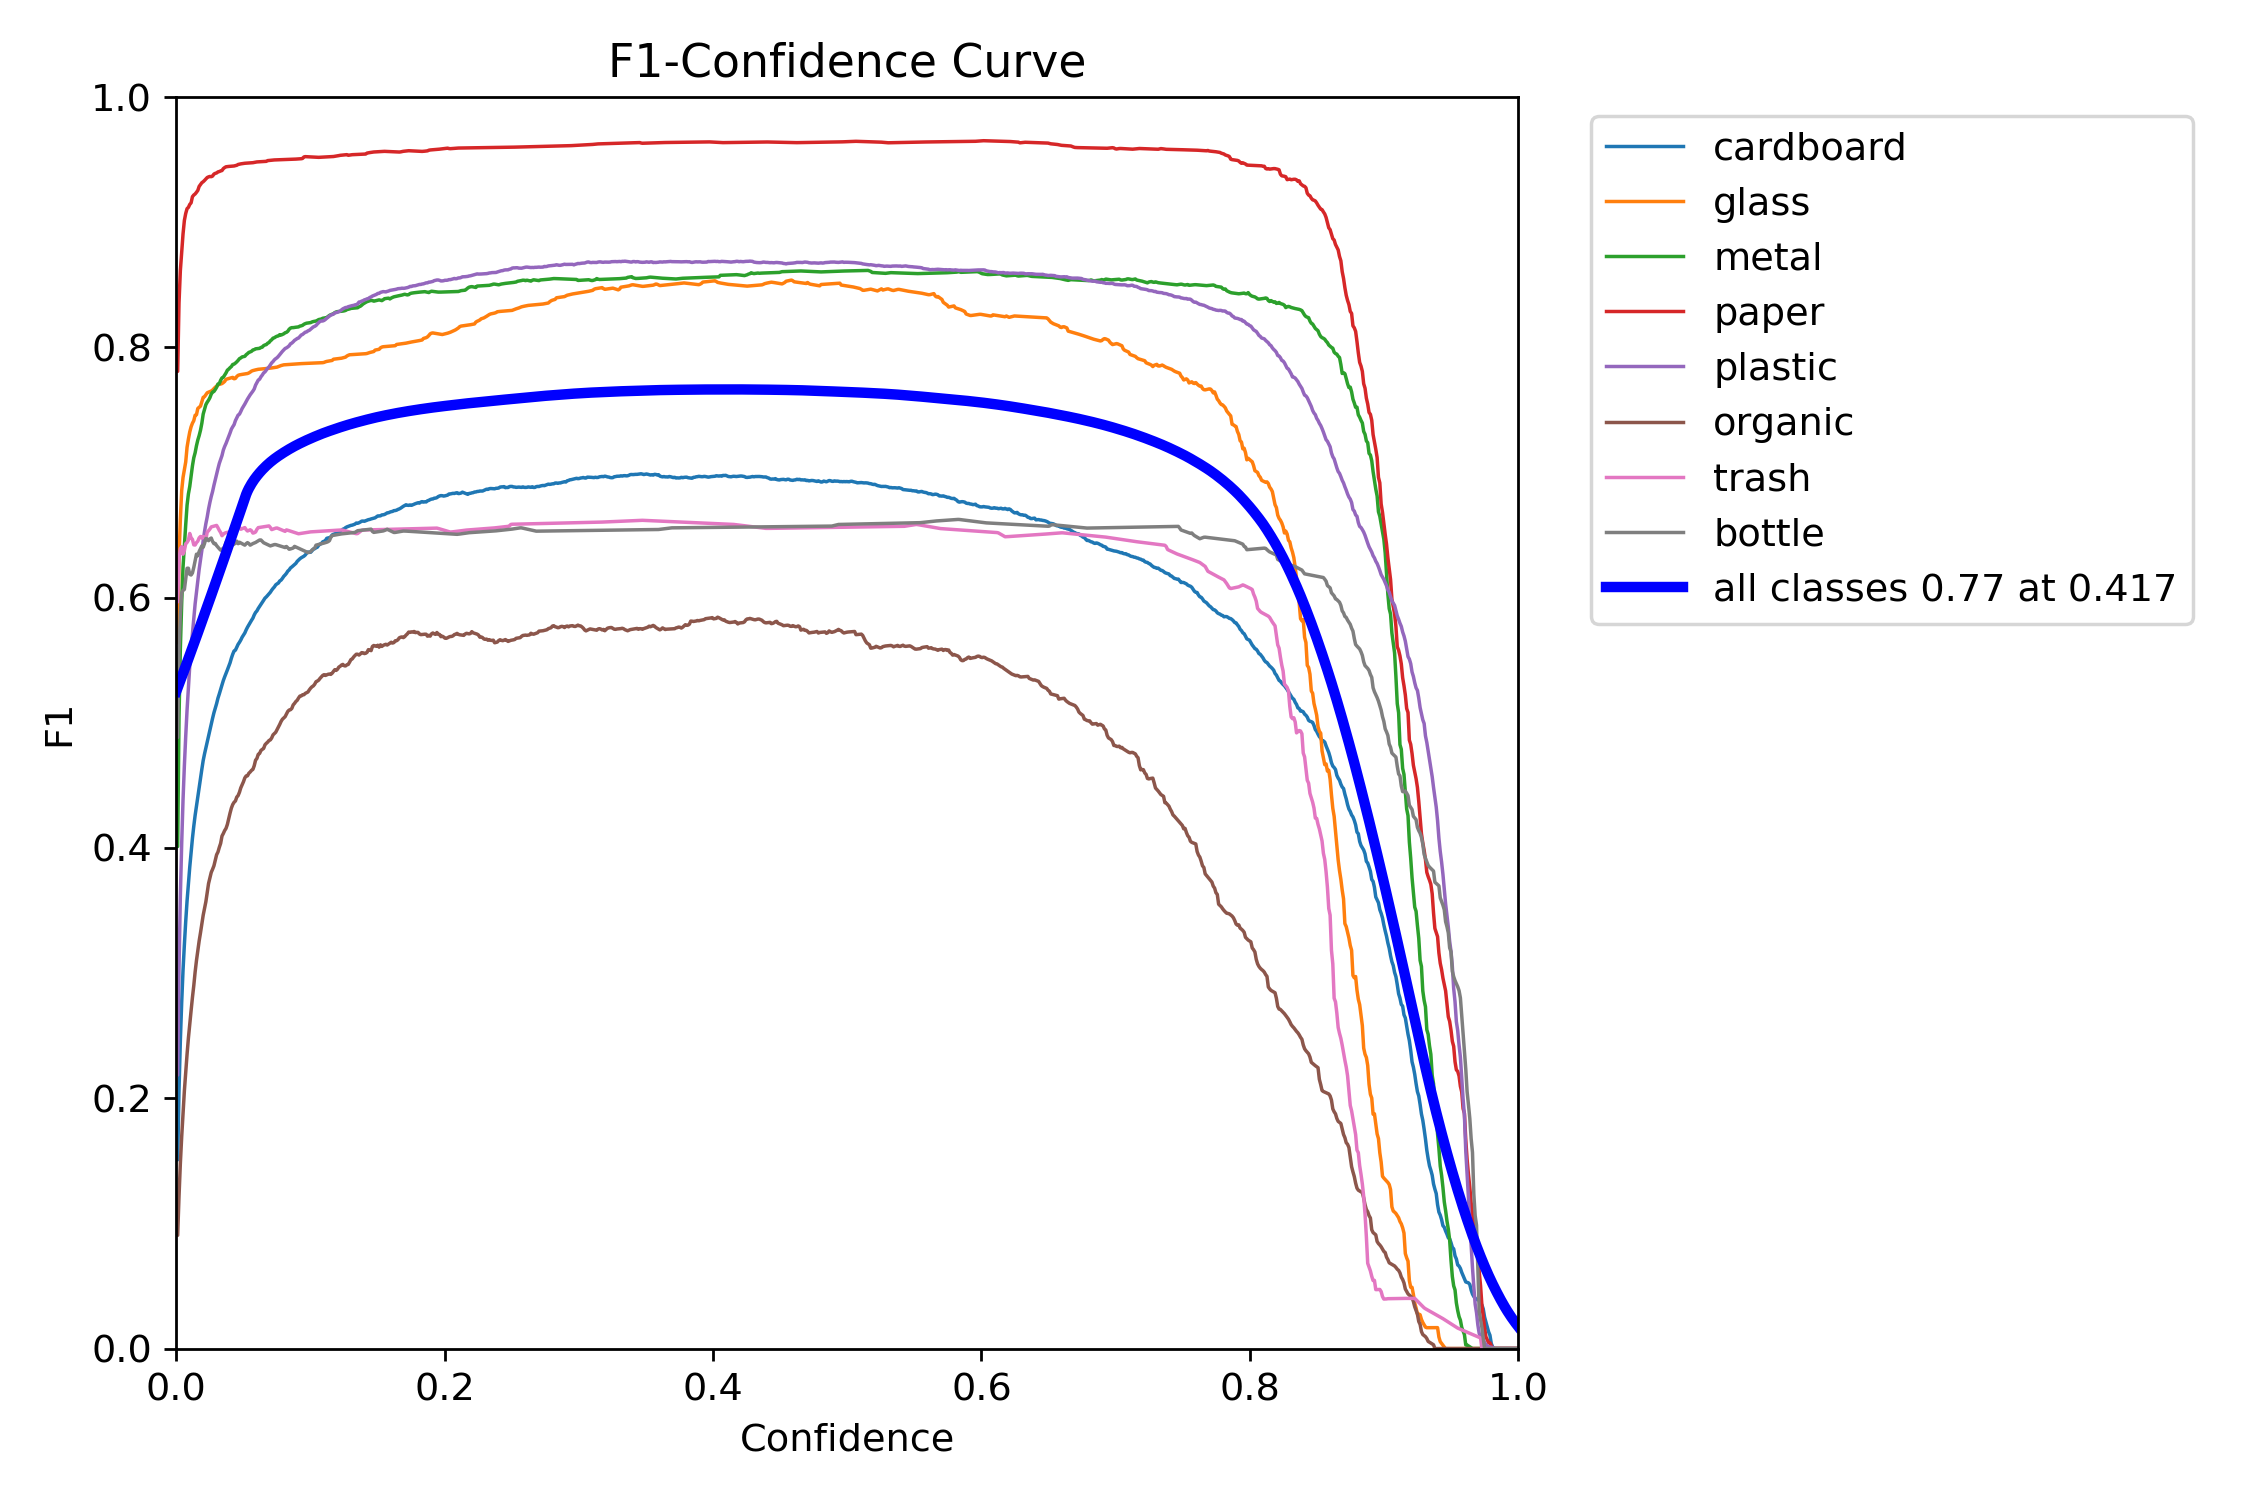

In [17]:
display(Image(filename=f'{model.trainer.save_dir}/BoxF1_curve.png'))

## 5. Test Prediction Sample
Running predictions on the Test Set to separate independent evaluation.


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2066 /content/merged_dataset/test/images/d0_11_X009_C312_1109_0_jpg.rf.249593a2da8a33c46e0aca976ac4e20f.jpg: 640x640 2 trashs, 13.0ms
image 2/2066 /content/merged_dataset/test/images/d0_11_X009_C509_0311_4_jpg.rf.4796f898339b2ff77068f221495f5ca9.jpg: 640x640 1 trash, 10.9ms
image 3/2066 /content/merged_dataset/test/images/d0_11_X009_C806_0925_4_jpg.rf.b1fb934e29fcad7db0030b92c483625a.jpg: 640x640 1 trash, 10.7ms
image 4/2066 /content/merged_datas

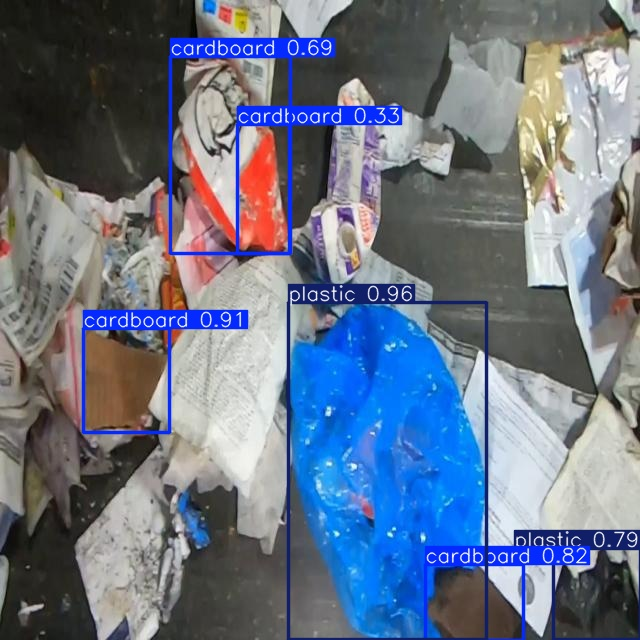

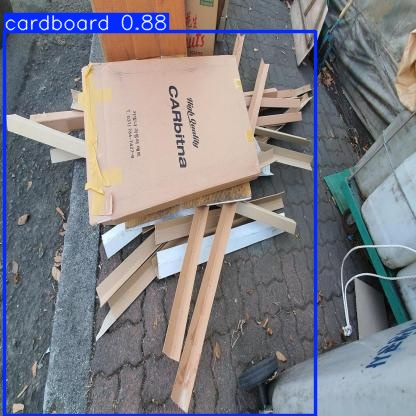

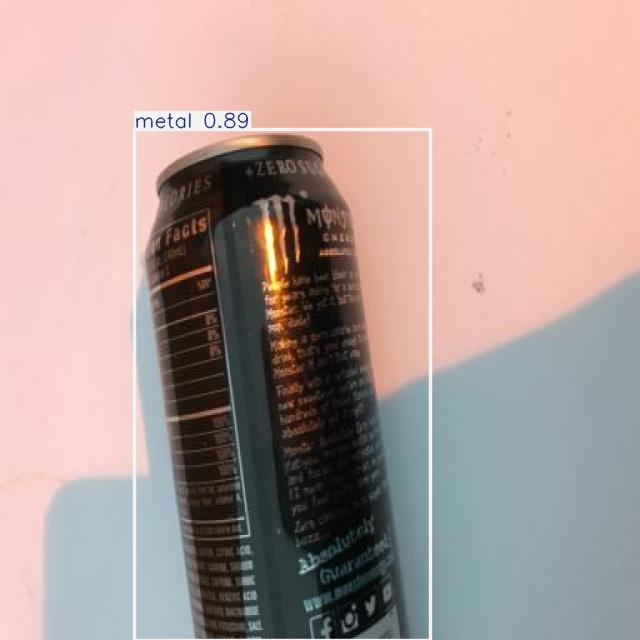

In [19]:
# Run prediction on test set
test_results = model.predict(
    source='/content/merged_dataset/test/images',
    save=True,
    save_txt=True,
    max_det=20,
    conf=0.25
)

# Display 3 random test results
import glob
import random

predicted_images = glob.glob(f'{test_results[0].save_dir}/*.jpg')
for img_path in random.sample(predicted_images, 3):
    display(Image(filename=img_path, width=400))

## 6. 💾 Export Results for Thesis
Zip all results (weights, plots, logs) and save to Drive.

In [20]:
output_zip = '/content/drive/MyDrive/YOLOv11_Thesis_Results.zip'
source_dir = model.trainer.save_dir

# Zip contents
!zip -r {output_zip} {source_dir}

print(f"✅ Training complete! All results saved to: {output_zip}")
print("Download this file to extract all graphs for your thesis.")

  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/ (stored 0%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/weights/ (stored 0%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/weights/last.pt (deflated 8%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/weights/best.pt (deflated 8%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/args.yaml (deflated 52%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/labels.jpg (deflated 26%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/train_batch0.jpg (deflated 3%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/train_batch1.jpg (deflated 5%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/train_batch2.jpg (deflated 2%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/results.csv (deflated 62%)
  adding: content/drive/MyDrive/YOLO_Runs/yolo11_medium_thesis3/train_batch32580.jpg (deflated 